In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [17]:
with open('jsonFiles/FolhaSP.json', 'r') as f:
    data = json.load(f)

rows = []
for measurement in data['info']:
    destination = measurement['dst_name']
    timestamp = measurement['endtime']
    for hop in measurement['result']:
        hop_num = hop['hop']
        for result in hop['result']:
            if 'rtt' in result:
                rows.append({
                    'destination': destination,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': result['rtt']
                })

df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o')
plt.title('Variação da Latência ao Longo do Tempo por Destino')
plt.xlabel('Tempo')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/FolhaSP.json'

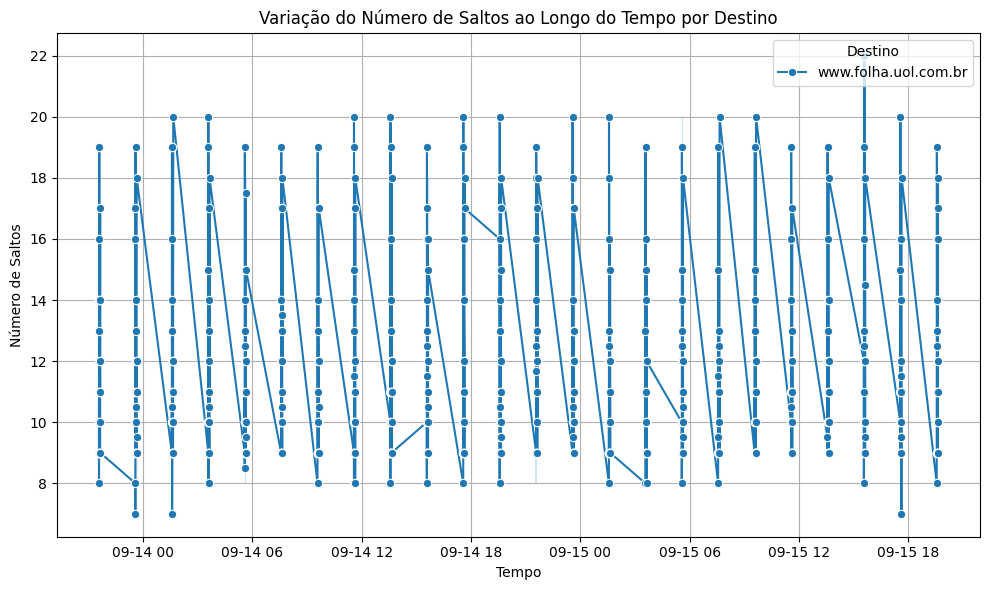

In [14]:
hop_data = []
for measurement in data['info']:
    destination = measurement['dst_name']
    timestamp = measurement['endtime']
    hop_count = len([hop for hop in measurement['result'] if 'result' in hop])
    hop_data.append({
        'destination': destination,
        'timestamp': timestamp,
        'hops': hop_count
    })

hop_df = pd.DataFrame(hop_data)
hop_df['timestamp'] = pd.to_datetime(hop_df['timestamp'], unit='s')

plt.figure(figsize=(10, 6))
sns.lineplot(data=hop_df, x='timestamp', y='hops', hue='destination', marker='o')
plt.title('Variação do Número de Saltos ao Longo do Tempo por Destino')
plt.xlabel('Tempo')
plt.ylabel('Número de Saltos')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


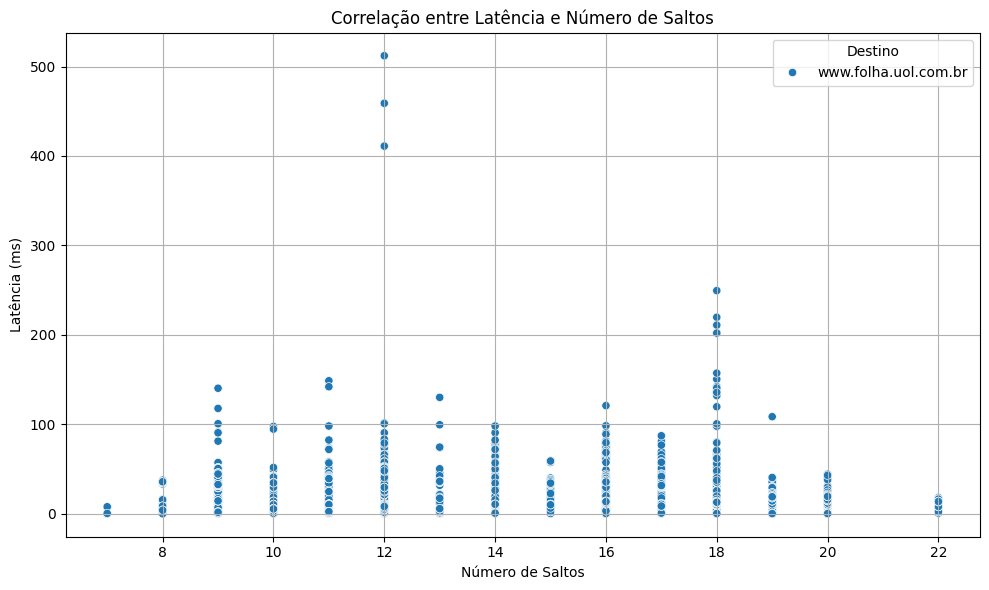

In [15]:
merged_df = pd.merge(df, hop_df, on=['destination', 'timestamp'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='hops', y='rtt', hue='destination')
plt.title('Correlação entre Latência e Número de Saltos')
plt.xlabel('Número de Saltos')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
